# Testing Recovery of DNA sequence post sequencing errors with different methods

In [31]:
%load_ext autoreload
%autoreload 2

## Loading the data
Currently simulating a single strand repeated about a 1000 times and repeating that 100 times. I will test the different methods on their ability to recover that strand. In post, I will repeat this for multiple strands in order to test how good clustering is as seperating strand repeats into individual clusters

In [1]:
from synthesis import NaiveSynthesisModel
from sequencing import NaiveSequencingModel
from tqdm.notebook import tqdm

strand_models = []
simulation_repeats = 100
repeats_per_strand = 1000
strand_length = 200
sequencing_model = NaiveSequencingModel(strand_length=strand_length)

for simulation_repeat in (range(simulation_repeats)):
    strand_model =  NaiveSynthesisModel(
            coupling_rate=9.9,
            strand_length=strand_length,
            repeats=repeats_per_strand,
            capping=True
        )
    strand_model.simulate_synthesis()
    strand_model.sequenced_strands = sequencing_model.simulate_full_sequencing(strand_model.synthesized_strands)
    strand_models.append(strand_model)


### Best Matching strand

In [9]:
def get_best_strand_match_recovery(reference, sequenced_strands):

    best_strand_match_recovery = 0
    
    for sequenced_strand in sequenced_strands:    
        recovery_percentage = sum([i==j for i, j in zip(sequenced_strand, reference)])/len(reference)

        if recovery_percentage > best_strand_match_recovery:
            best_strand_match_recovery = recovery_percentage

    return best_strand_match_recovery

In [10]:

best_strand_match_strand_recoveries = []

for strand_model in strand_models:

    original_strand = strand_model.strand
    sequenced_strands = strand_model.sequenced_strands

    best_strand_match_recovery = get_best_strand_match_recovery(
        reference=original_strand,
        sequenced_strands=sequenced_strands
    )

    best_strand_match_strand_recoveries.append(
        best_strand_match_recovery
    )


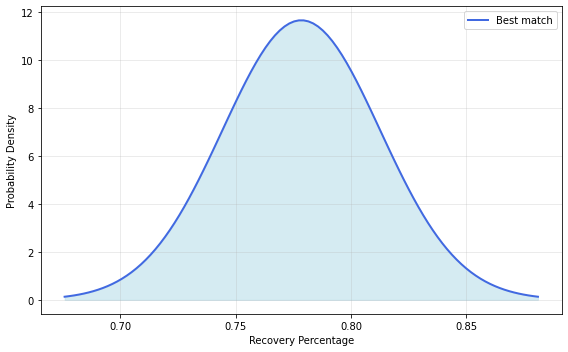

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math


def plot_gaussian_recovery_percentage(mu, sigma, label="", title="", show=False):
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    
    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, color="royalblue", linewidth=2, label=label)
    plt.fill_between(x, y, color="lightblue", alpha=0.5)  # Fill under curve
    
    # Annotate mean and ±1 std deviation
    #plt.axvline(mu, color="red", linestyle="--", label=f"Mean: {mu:.2f}")
    
    # Plot settings
    plt.xlabel("Recovery Percentage")
    plt.ylabel("Probability Density")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if show:
        plt.show()


plot_gaussian_recovery_percentage(
    np.mean(best_strand_match_strand_recoveries),
    np.std(best_strand_match_strand_recoveries), label='Best match', show=True)


### Consensus

In [18]:
def get_recovery_percentage(reference, decoded_strand):
    return sum([
        i==j for i, j in zip(reference, decoded_strand)
        ])/len(reference)

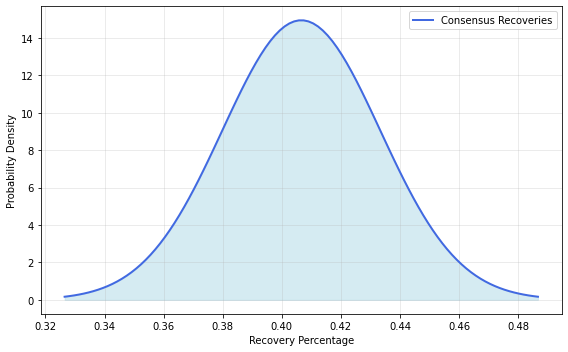

In [22]:

consensus_recoveries = []

for strand_model in strand_models:

    original_strand = strand_model.strand
    sequenced_strands = strand_model.sequenced_strands

    consensus_recovery = sequencing_model.consensus_decoding(
        sequenced_strands=sequenced_strands,
        original_strand=original_strand
    )

    consensus_recoveries.append(consensus_recovery)

plot_gaussian_recovery_percentage(
    np.mean(consensus_recoveries),
    np.std(consensus_recoveries), label='Consensus Recoveries', show=True)

### Longest strand Recovery

In [15]:
def get_longest_strand_match_recovery(reference, sequenced_strands):

    longest_strand = ""
    for strand in sequenced_strands:
        if len(strand) > len(longest_strand) and len(strand) <= len(reference):
            longest_strand = strand
            
    return sum([i==j for i, j in zip(longest_strand, reference)])/len(reference)

In [16]:

longest_strand_recoveries = []

for strand_model in strand_models:

    original_strand = strand_model.strand
    sequenced_strands = strand_model.sequenced_strands

    longest_strand_recovery = get_longest_strand_match_recovery(
        reference=original_strand,
        sequenced_strands=sequenced_strands
    )

    longest_strand_recoveries.append(
        longest_strand_recovery
    )


NameError: name 'consensus_recoveries' is not defined

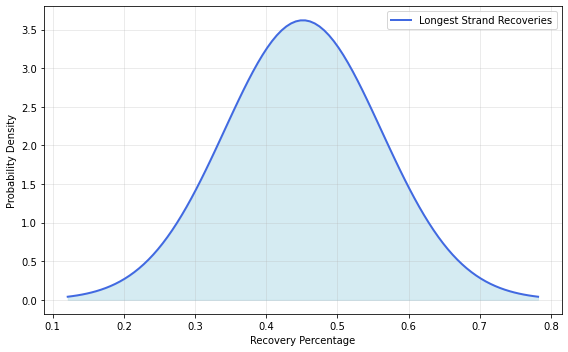

In [17]:
plot_gaussian_recovery_percentage(
    np.mean(longest_strand_recoveries),
    np.std(longest_strand_recoveries), label='Longest Strand Recoveries', show=False)

plot_gaussian_recovery_percentage(
    np.mean(consensus_recoveries),
    np.std(consensus_recoveries), label='Consensus Recoveries', show=False)


### Clustering

In [47]:
from seq_stat import cluster_seq

cluster_recoveries = []

for strand_model in (strand_models):

    original_strand = strand_model.strand
    sequenced_strands = strand_model.sequenced_strands

    cluster_recovery = cluster_seq(
        sequences=sequenced_strands,
        reference_sequence=original_strand
    )

    cluster_recoveries.append(
        cluster_recovery
    )


plot_gaussian_recovery_percentage(
    np.mean(cluster_recoveries),
    np.std(cluster_recoveries), label='Cluster Recoveries', show=False)

ValueError: The 1d arrays must have equal lengths.

In [45]:
from seq_stat import align, cluster_seq
from sklearn.cluster import KMeans  # Clustering algorithm
from sklearn.decomposition import PCA  # Dimensionality reduction
from sklearn.feature_extraction.text import CountVectorizer  # Text to count matrix
from sklearn.metrics.pairwise import euclidean_distances  # Distance calculation
import matplotlib.pyplot as plt  # Plotting library
from collections import Counter
from scipy.spatial.distance import hamming
from sequencing import get_base_votes, align


def get_longest_strand(sequenced_strands, reference):

    longest_strand = ""
    for strand in sequenced_strands:
        if len(strand) > len(longest_strand) and len(strand) <= len(reference):
            longest_strand = strand
            
    return longest_strand

def aligned_consensus(sequenced_strands, reference):


    longest_strand = get_longest_strand(sequenced_strands, reference)
    strand_length = len(reference)

    sequenced_strands = [
                    align(sequenced_strand, longest_strand)
                    if len(sequenced_strand) > 20
                    else "" * strand_length
                    for sequenced_strand in sequenced_strands]
    
    A_votes, T_votes, C_votes, G_votes = get_base_votes(
            strand_length,
            sequenced_strands)

    consensus_strand = ""
    bases = ['A', 'T', 'C', 'G']
    for i in range(strand_length):
        votes = [A_votes[i], T_votes[i], C_votes[i], G_votes[i]]
        consensus_strand += bases[np.argmax(votes)]

    return sum([
    i==j for i, j in zip(reference, consensus_strand)
    ])/len(reference), consensus_strand

## Understanding Clustering

In [2]:
selected_model = strand_models[0]
original_strand = selected_model.strand
sequenced_strands = selected_model.sequenced_strands

In [65]:
n_clusters = 5

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter
from itertools import product

# Sample DNA sequences
dna_sequences = sequenced_strands

# Step 1: Define all possible k-mers (e.g., 2-mers here)
k = 2  # Adjust k as needed for the level of detail
kmers = [''.join(p) for p in product("ATCG", repeat=k)]

# Step 2: Define a function to count k-mers in a sequence
def kmer_count(sequence, k, kmers):
    counts = Counter([sequence[i:i+k] for i in range(len(sequence) - k + 1)])
    return np.array([counts[kmer] for kmer in kmers])

# Step 3: Create a feature matrix of k-mer frequency vectors
feature_matrix = np.array([kmer_count(seq, k, kmers) for seq in dna_sequences])

# Step 4: Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(feature_matrix)


In [67]:
clusters = [[] for i in range(len(labels))]

for label, strand in zip(labels, sequenced_strands):
    clusters[label].append(strand)

In [68]:

consensus_strands = []
recovery, consensus = aligned_consensus(sequenced_strands, original_strand)
print(recovery)
for i in clusters:
    if i:
        recovery, consensus = aligned_consensus(i, original_strand)
        print(recovery)
        consensus_strands.append(consensus)

0.545
0.575
0.54
0.49
0.555
0.485


In [69]:
aligned_consensus(consensus_strands, original_strand)

(0.54,
 'CCCACTCCGGTTTGGTTCAAAAAAAAAATGGGGGGGGGGGGGGGGGCCCCCCTTTTTAAATTTTTTTTTCCCCCGGGGGGGGGAAAAAAAAGGGGGGGGGGTTCCCCCCCCCCCCTTTTCCCCAAAAAAAGCATTTTTTTTTTTTTAAAAACGGGGGGGGGGGGTTTTCCCCCCGCCCCGGGGGAAGGGGGGGGAAGAAA')

In [ ]:
from sequencing import consensus_decoding


consensus_decoding(consensus_strands, original_strand)

(0.535,
 'CCCACTCCGGTTTGGGGCAAAAAAAAAATGGGGGGGGGGGGGGGGGCCCCCCCTTTTAAATTTTTTTTTGGGCCGGGGGGGGGAAAAAAAAGGGGGGGGGGCCCCCCCCCCCCCCCTTTCCCTTAAAAAAGCTTCTTTTTTTTTTTAAAAACGGGGGGGGGGGGTTTTCCCCCCGCCCCGAAGGAAGGGGGGACCGGAAA')

In [30]:

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter
from itertools import product
from seq_stat import align, cluster_seq
from sequencing import get_base_votes, consensus_decoding

def get_longest_strand(sequenced_strands, strand_length):

    longest_strand = ""
    for strand in sequenced_strands:
        if len(strand) > len(longest_strand) and len(strand) <= strand_length:
            longest_strand = strand
            
    return longest_strand


def aligned_consensus(sequenced_strands, strand_length):


    longest_strand = get_longest_strand(sequenced_strands, strand_length)

    aligned_strands = [
                    align(sequenced_strand, longest_strand)
                    if len(sequenced_strand) > 20
                    else "" * strand_length
                    for sequenced_strand in sequenced_strands]
    
    return consensus_decoding(aligned_strands, strand_length)

def weighted_aligned_cluster(sequenced_strands, strand_length, n_clusters=3, consensus=False):
    
    # Sample DNA sequences
    dna_sequences = sequenced_strands

    # Step 1: Define all possible k-mers (e.g., 2-mers here)
    kmers = [''.join(p) for p in product("ATCG", repeat=2)]

    # Step 2: Define a function to count k-mers in a sequence
    def kmer_count(sequence, k, kmers):
        counts = Counter([sequence[i:i+k] for i in range(len(sequence) - k + 1)])
        return np.array([counts[kmer] for kmer in kmers])

    # Step 3: Create a feature matrix of k-mer frequency vectors
    feature_matrix = np.array([kmer_count(seq, 2, kmers) for seq in dna_sequences])

    # Step 4: Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(feature_matrix)

    # Seperating the strands based on their label
    clusters = [[] for i in range(len(labels))]

    for label, strand in zip(labels, sequenced_strands):
        clusters[label].append(strand)

    consensus_strands = []

    for i in clusters:
        consensus_strands.append(aligned_consensus(i, strand_length))

    if not consensus:
        return aligned_consensus(consensus_strands, strand_length)

    return consensus_decoding(consensus_strands, strand_length)
   



In [ ]:

from utils import get_recovery_percentage
from decoding import weighted_aligned_cluster

for i in range(50, len(sequenced_strands), 200):
    consensus_strand = weighted_aligned_cluster(sequenced_strands[:i], strand_length=len(original_strand), n_clusters=10)
    print(get_recovery_percentage(consensus_strand, original_strand))

### Actual Sequencing Data